# MSCA 31009 Machine Learning and Predictive Analysis - Final Project

Nikitha Gopal

In [1]:
!pip install pip
!pip install tensorflow
!pip install keras tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikeras
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.9 MB/s eta 0:00:00


In [3]:
# import dependencies

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import librosa
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Raga Classification: 


The objective is to detect the raga that the songs is associated with.

There are 8 classes (ragas) that we are focusing on for this project. Each raga includes 30 second sound bits. Splinting into 2 categories: major rags and minor rags


<b> Part A: Data Processing</b>

The data need to be process and standardized. Conducting the follwoing to the audio file.
- converted to normalized pitch
- converted to melspectrogram

 

In [5]:
# Set the path to your dataset directory
dataset_dir = "/content/drive/My Drive/Colab_Notebooks/audio_files/train"

# Define the list of classification labels
major = ['bhoop', 'malkauns', 'sarang', 'yaman']
minor = ['asavari', 'bageshree', 'bhairavi',  'dkanada']

In [7]:
# Define the class labels
class_labels = ['major', 'mine']

In [13]:
from skimage.transform import resize

def pre_process(audio, sr):

  common_tonic = 'C' 
  common_tonic_midi = librosa.note_to_midi(common_tonic)
  
  # Normalize audio to common tonic pitch
  original_tonic = librosa.estimate_tuning(y=audio, sr=sr)
  shift_factor = librosa.midi_to_hz(common_tonic_midi) - original_tonic
  normalized_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=float(shift_factor))
    
  # Calculate mel-spectrogram from the normalized audio
  mel_spec = librosa.feature.melspectrogram(y=normalized_audio, sr=sr)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

  # Resize the mel-spectrogram to the target shape
  target_shape = (128, 2054)
  resized_spec = resize(mel_spec_db, target_shape)

  return resized_spec

In [14]:
# Define the paths to the major and minor folders
major_folder = "/content/drive/My Drive/Colab_Notebooks/audio_files/train/major"
minor_folder = "/content/drive/My Drive/Colab_Notebooks/audio_files/train/minor"

# Create empty lists to store data and labels
audio_data = []
labels = []

# Load major files
for filename in os.listdir(major_folder):
    file_path = os.path.join(major_folder, filename)
    audio, sr = librosa.load(file_path, sr=None)
    audio_processed = pre_process(audio, sr)
    audio_data.append(audio_processed)
    labels.append("major")

# Load minor files
for filename in os.listdir(minor_folder):
    file_path = os.path.join(minor_folder, filename)
    audio, sr = librosa.load(file_path, sr=None)
    audio_processed = pre_process(audio, sr)
    audio_data.append(audio_processed)
    labels.append("minor")

# Convert the lists to numpy arrays
audio_data = np.array(audio_data)
labels = np.array(labels)

# Print the shape of the audio data and labels arrays
print("Audio data shape:", audio_data.shape)
print("Labels shape:", labels.shape)

Audio data shape: (321, 128, 2054)
Labels shape: (321,)


In [15]:
# Load Test Data
test_data_dir = "/content/drive/My Drive/Colab_Notebooks/audio_files/test"

# Create empty lists to store test data and labels
test_audio_data = []
test_labels = []


In [16]:
# Iterate through test files
for filename in os.listdir(test_data_dir):
    file_path = os.path.join(test_data_dir, filename)
    audio, sr = librosa.load(file_path, sr=None)
    audio_processed = pre_process(audio, sr)


    test_audio_data.append(audio_processed)

    # Assign labels for test data 
    l = filename.split('_')[0]
    if l[:-2].lower() in major:
      test_labels.append("major")
    else:
      test_labels.append("minor")
    
# Convert the lists to numpy arrays
test_audio_data = np.array(test_audio_data)
test_labels = np.array(test_labels)

# Print the shape of the test audio data and labels arrays
print("Test Audio data shape:", test_audio_data.shape)
print("Test Labels shape:", test_labels.shape)

print(test_labels)

Test Audio data shape: (42, 128, 2054)
Test Labels shape: (42,)
['minor' 'minor' 'minor' 'minor' 'minor' 'minor' 'minor' 'minor' 'minor'
 'minor' 'minor' 'minor' 'minor' 'minor' 'minor' 'major' 'major' 'major'
 'major' 'major' 'major' 'major' 'major' 'major' 'major' 'major' 'major'
 'major' 'major' 'major' 'major' 'major' 'major' 'major' 'major' 'major'
 'major' 'minor' 'minor' 'minor' 'minor' 'minor']


In [69]:
y_test_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

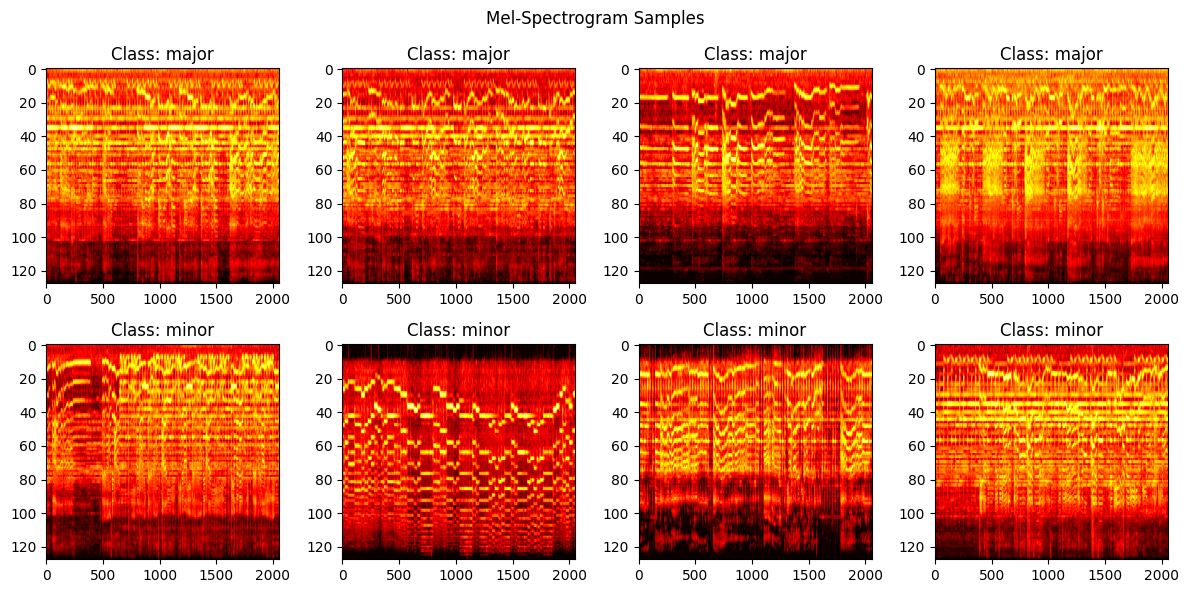

In [32]:
import random
import matplotlib.pyplot as plt

# Get indices of major and minor samples
major_indices = [4, 29, 68, 100]
minor_indices = [201, 300, 175, 270]

# Select 4 random samples from each class
major_samples = random.sample(major_indices, 4)
minor_samples = random.sample(minor_indices, 4)

# Concatenate the major and minor sample indices
sample_indices = np.concatenate([major_samples, minor_samples])

# Plot the mel-spectrogram samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Mel-Spectrogram Samples')

for i, index in enumerate(sample_indices):
    row = i // 4
    col = i % 4
    mel_spec = audio_data[sample_indices[i]]
    label = labels[sample_indices[i]]
    axes[row, col].imshow(mel_spec, aspect='auto', cmap='hot')
    axes[row, col].set_title(f'Class: {label}')

plt.tight_layout()
plt.show()


In [33]:
X_train_reshaped = audio_data.reshape(audio_data.shape[0], audio_data.shape[1], audio_data.shape[2], 1)
X_test_reshaped = test_audio_data.reshape(test_audio_data.shape[0], test_audio_data.shape[1], test_audio_data.shape[2], 1)

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(labels)
y_test_encoded = label_encoder.transform(test_labels)

<b> Part B: Model 1 - Baseline CNN </b>


 

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(128, 2054, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 2052, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 1026, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1034208)           0         
                                                                 
 dense (Dense)               (None, 64)                66189376  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 66,189,601
Trainable params: 66,189,601
Non-trainable params: 0
____________________________________________

Epoch 1/5
11/11 [==============================] - 62s 5s/step - loss: 2362.2915 - accuracy: 0.4984 - val_loss: 482.7893 - val_accuracy: 0.4762
Epoch 2/5
11/11 [==============================] - 64s 5s/step - loss: 194.0140 - accuracy: 0.5358 - val_loss: 64.5080 - val_accuracy: 0.5238
Epoch 3/5
11/11 [==============================] - 61s 5s/step - loss: 10.2195 - accuracy: 0.5202 - val_loss: 0.6753 - val_accuracy: 0.4762
Epoch 4/5
11/11 [==============================] - 71s 6s/step - loss: 6.7657 - accuracy: 0.5358 - val_loss: 0.6390 - val_accuracy: 0.4762
Epoch 5/5
11/11 [==============================] - 56s 5s/step - loss: 0.6094 - accuracy: 0.5358 - val_loss: 0.6922 - val_accuracy: 0.4762


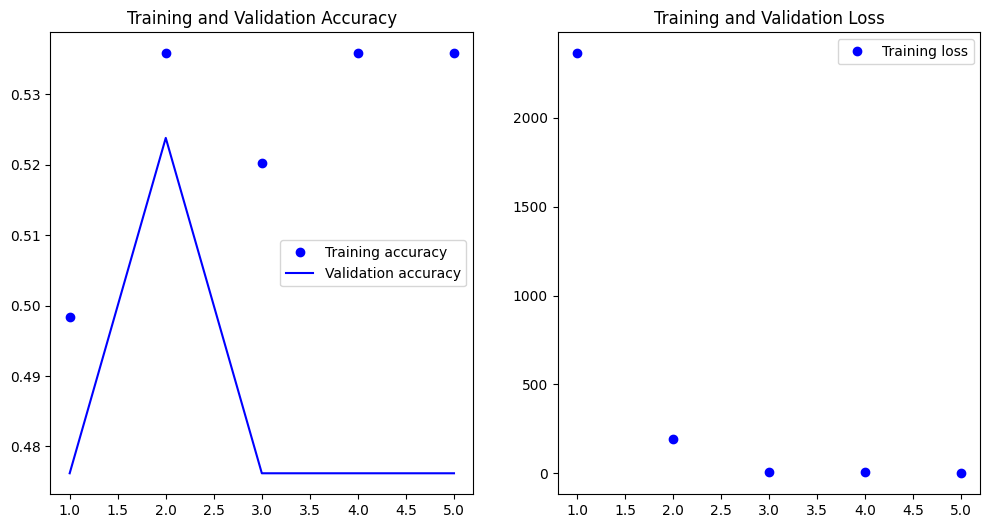

In [36]:
history = model.fit(X_train_reshaped, y_train_encoded, batch_size=32, epochs=5, validation_data=(X_test_reshaped, y_test_encoded))

# Plotting the training and validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [37]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)

print("Accuracy:", accuracy)

2/2 [==============================] - 3s 782ms/step - loss: 0.6922 - accuracy: 0.4762
Accuracy: 0.4761904776096344


In [38]:
y_pred = model.predict(X_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int)

2/2 [==============================] - 2s 473ms/step


In [ ]:
y_pred_train= model.predict(X_train_reshaped)
y_pred_classes_train = (y_pred_train > 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_train_encoded, y_pred_classes_train)

cm2

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_classes)

cm

array([[ 0, 22],
       [ 0, 20]])

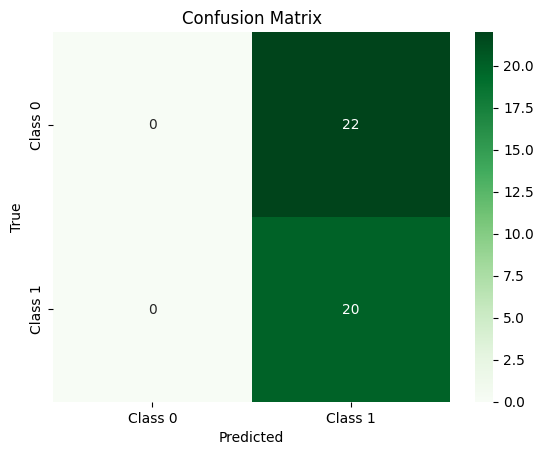

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Class 0', 'Class 1']  # Define your class names accordingly
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

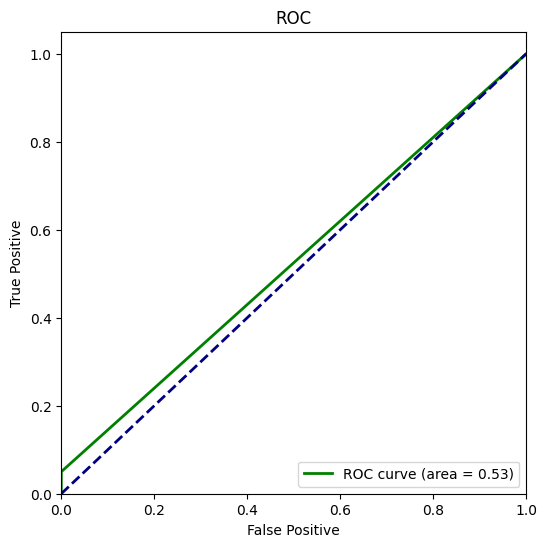

In [48]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

<b> Part C: Model 2 - CNN </b>

Hyperparameter tuning

In [51]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', min_value=8, max_value=32, step=8),
                            kernel_size=(hp.Choice('kernel_size', values=[3, 5]), hp.Choice('kernel_size', values=[3, 5])),
                            activation='relu', input_shape=(128, 2054, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='binary_classification')

# Perform the hyperparameter search
tuner.search(X_train_reshaped, y_train_encoded, epochs=10, validation_data=(X_test_reshaped, y_test_encoded))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Trial 10 Complete [00h 21m 28s]
val_accuracy: 0.523809552192688

Best val_accuracy So Far: 0.9285714030265808
Total elapsed time: 02h 43m 36s
2/2 [==============================] - 5s 943ms/step - loss: 0.4835 - accuracy: 0.9286
Test Loss: 0.48347795009613037
Test Accuracy: 0.9285714030265808


In [61]:
loss, accuracy = best_model.evaluate(X_test_reshaped, y_test_encoded)

print("Accuracy:", accuracy)

2/2 [==============================] - 6s 755ms/step - loss: 0.4835 - accuracy: 0.9286
Accuracy: 0.9285714030265808


In [68]:
loss, accuracy = best_model.evaluate(X_train_reshaped, y_train_encoded)

print("Accuracy:", accuracy)

11/11 [==============================] - 30s 3s/step - loss: 0.0124 - accuracy: 0.9938
Accuracy: 0.9937694668769836


In [52]:
y_pred_train= best_model.predict(X_train_reshaped)
y_pred_classes_train = (y_pred_train > 0.5).astype(int)

11/11 [==============================] - 30s 3s/step


In [53]:
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_train_encoded, y_pred_classes_train)

cm2

array([[149,   0],
       [  2, 170]])

In [54]:
y_pred = best_model.predict(X_test_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int)

2/2 [==============================] - 5s 769ms/step


In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_classes)

cm

array([[22,  0],
       [ 3, 17]])

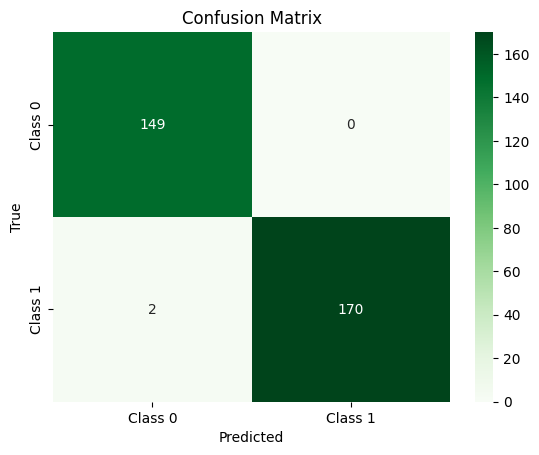

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Class 0', 'Class 1']  # Define your class names accordingly
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

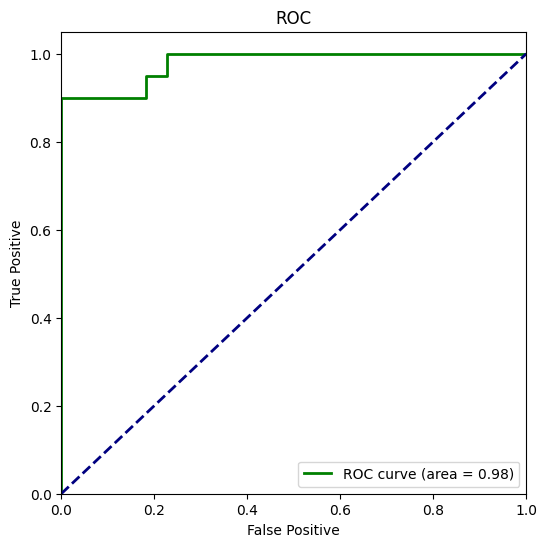

In [58]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [67]:
from sklearn.metrics import f1_score

# Assuming you have the true labels in y_true and the predicted labels in y_pred
f1 = f1_score(y_test_encoded, y_pred_classes)

# If you have a binary classification problem, you can specify the average parameter
# to calculate the F1 score for a specific class or compute the average of multiple classes
# For example, to compute the F1 score for the positive class in a binary classification problem:
f1_positive = f1_score(y_test_encoded, y_pred_classes, pos_label=1)

# If you have a multi-class classification problem, you can specify the average parameter
# to compute the F1 score for each class or compute the average of all classes
# For example, to compute the macro-average F1 score:
f1_macro = f1_score(y_test_encoded, y_pred_classes, average='macro')


print(f1, f1_positive)

0.9189189189189189 0.9189189189189189


In [59]:
tuner.results_summary()

Results summary
Results in tuner_directory/binary_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
filters: 24
kernel_size: 5
units: 128
learning_rate: 0.0001
Score: 0.9285714030265808

Trial 07 summary
Hyperparameters:
filters: 8
kernel_size: 5
units: 128
learning_rate: 0.001
Score: 0.8809523582458496

Trial 02 summary
Hyperparameters:
filters: 32
kernel_size: 3
units: 96
learning_rate: 0.0001
Score: 0.8095238208770752

Trial 00 summary
Hyperparameters:
filters: 32
kernel_size: 3
units: 96
learning_rate: 0.01
Score: 0.6666666865348816

Trial 01 summary
Hyperparameters:
filters: 16
kernel_size: 3
units: 96
learning_rate: 0.01
Score: 0.6666666865348816

Trial 04 summary
Hyperparameters:
filters: 32
kernel_size: 5
units: 64
learning_rate: 0.001
Score: 0.523809552192688

Trial 05 summary
Hyperparameters:
filters: 24
kernel_size: 5
units: 32
learning_rate: 0.01
Score: 0.523809552192688

Trial 08 summary
Hyperparameters

In [60]:
trials = tuner.oracle.get_best_trials(num_trials=10)
for trial in trials:
    print("Trial ID:", trial.trial_id)
    print("Hyperparameters:", trial.hyperparameters.values)
    print("Accuracy:", trial.metrics.get_best_value('accuracy'))
    print()

Trial ID: 06
Hyperparameters: {'filters': 24, 'kernel_size': 5, 'units': 128, 'learning_rate': 0.0001}
Accuracy: 0.9875389337539673

Trial ID: 07
Hyperparameters: {'filters': 8, 'kernel_size': 5, 'units': 128, 'learning_rate': 0.001}
Accuracy: 1.0

Trial ID: 02
Hyperparameters: {'filters': 32, 'kernel_size': 3, 'units': 96, 'learning_rate': 0.0001}
Accuracy: 0.722741425037384

Trial ID: 00
Hyperparameters: {'filters': 32, 'kernel_size': 3, 'units': 96, 'learning_rate': 0.01}
Accuracy: 0.9688473343849182

Trial ID: 01
Hyperparameters: {'filters': 16, 'kernel_size': 3, 'units': 96, 'learning_rate': 0.01}
Accuracy: 0.9595015645027161

Trial ID: 04
Hyperparameters: {'filters': 32, 'kernel_size': 5, 'units': 64, 'learning_rate': 0.001}
Accuracy: 0.4984423816204071

Trial ID: 05
Hyperparameters: {'filters': 24, 'kernel_size': 5, 'units': 32, 'learning_rate': 0.01}
Accuracy: 0.5264797210693359

Trial ID: 08
Hyperparameters: {'filters': 32, 'kernel_size': 3, 'units': 32, 'learning_rate': 0.001